<a href="https://colab.research.google.com/github/jaydent22/661-final-project/blob/main/gpt-neo/CoT/661_GPT_Neo_Hate_Speech_CoT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT-Neo Hate Speech Chain of Thought

This notebook will use chain-of-thought prompting on a pretrained GPT-Neo model to measure its performance on the Hate Speech dataset from a White Supremacist Forum (de Gibert et al 2018).

## Setup

In [ ]:
!pip install transformers datasets pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from transformers import GPT2TokenizerFast, GPTNeoForCausalLM
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
from time import time
import random

In [ ]:
cuda = torch.device('cuda')

In [ ]:
model_id = "EleutherAI/gpt-neo-2.7B"

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

In [ ]:
model = GPTNeoForCausalLM.from_pretrained(model_id)
model.to(cuda)
model.eval()
print(model)

model.safetensors:   0%|          | 0.00/10.7G [00:00<?, ?B/s]

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 2560)
    (wpe): Embedding(2048, 2560)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-31): 32 x GPTNeoBlock(
        (ln_1): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=2560, out_features=2560, bias=False)
            (v_proj): Linear(in_features=2560, out_features=2560, bias=False)
            (q_proj): Linear(in_features=2560, out_features=2560, bias=False)
            (out_proj): Linear(in_features=2560, out_features=2560, bias=True)
          )
        )
        (ln_2): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=2560, out_features=10240, bias=True)
          (c_proj)

In [ ]:
def predict_hate(text):
  inputs = tokenizer(wrap_sentence(text), truncation=True, return_tensors="pt").to(cuda)
  output = model.generate(
      **inputs,
      max_new_tokens=50,
      num_return_sequences=1,
      pad_token_id=tokenizer.eos_token_id,
      # no_repeat_ngram_size=2,
      # repetition_penalty=1.7,
      # do_sample=True,
      # temperature=0.2,
      # top_k=50,
      # top_p=0.9,
  )
  return tokenizer.decode(output[0], skip_special_tokens=True)

## Dataset

In [ ]:
! git clone https://github.com/Vicomtech/hate-speech-dataset.git

Cloning into 'hate-speech-dataset'...
remote: Enumerating objects: 10785, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 10785 (delta 6), reused 0 (delta 0), pack-reused 10771 (from 1)
Receiving objects: 100% (10785/10785), 1.16 MiB | 7.94 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [ ]:
!ls

hate-speech-dataset  sample_data


In [ ]:
df = pd.read_csv('hate-speech-dataset/annotations_metadata.csv')
df.head()

,file_id,user_id,subforum_id,num_contexts,label
0,12834217_1,572066,1346,0,noHate
1,12834217_2,572066,1346,0,noHate
2,12834217_3,572066,1346,0,noHate
3,12834217_4,572066,1346,0,hate
4,12834217_5,572066,1346,0,noHate


In [ ]:
df['label'].value_counts()

,count
label,
noHate,9507
hate,1196
relation,168
idk/skip,73


In [ ]:
relation_df = df[df['label'] == 'relation']
for i in range(10):
  with open(f'hate-speech-dataset/all_files/{relation_df.iloc[i]["file_id"]}.txt', 'r') as file:
    file_content = file.read()
    print(file_content)
    print()

You are telling me that 78 % of kids under 6 in Frankfurt are all foreigners ?

Jeeze its worst than the UK .

So far today I 've come across the words scum , slut and bitch .

All too describe my sisters .

The Indian teenager was showing the Caucasian American girl how to dissolve cow dung in water , and then use a broom to spread the filth all over the floor of their house .

Certain cultural practices just tell you volumes about a people , do n't they ?

Here is my old school picture i think it was in 1994 .

I hope such classes will be the future of all Russia

No doubt the bulk of her votes came from the ever growing chinese immigrant community around Belfast .

Scum .



In [ ]:
skip_df = df[df['label'] == 'idk/skip']
for i in range(10):
  with open(f'hate-speech-dataset/all_files/{skip_df.iloc[i]["file_id"]}.txt', 'r') as file:
    file_content = file.read()
    print(file_content)
    print()

Glædelig jul !

Det er forresten en ting til Órkneyjar vil si deg , `` Tack så mycket . ''

Jag har inte själv varit med någon gång men jag har stor respekt för de som deltar .

Suomalainen totta kai !

ApÃ © ro gÃ © ant : trois jeunes soupÃ § onnÃ © s de viol https : //www.stormfront.org/forum/t809905/

BaoFeng 左眼技术 采用左眼专利技术 利用cpu和gpu有效提升画质 在线高清 shd专利技术 , 1m带宽 流畅播放720p高清视频 3d技术

Sørensen , 19 år , er født 8. april 1982 i Kolding .

Har taget en HH-eksamen på handelsskolen i Nyborg .

Medlem af DFUìs bestyrelse .

I sin fritid går Karina Sørensen på jagt med sin far , dyrker styrketræning eller nyder tilværelsen med sin kæreste .



In [ ]:
df = df.loc[df['label'] != 'relation']
print(len(df))
df = df.loc[df['label'] != 'idk/skip']
print(len(df))
print(df['label'].value_counts())

10776
10703
label
noHate    9507
hate      1196
Name: count, dtype: int64


In [ ]:
_, val_test_df = train_test_split(df, test_size=0.2, stratify=df['label'])
_, test_df = train_test_split(val_test_df, test_size=0.5, stratify=val_test_df['label'])
print(len(test_df))

1071


In [ ]:
for i, row in test_df.iterrows():
  with open(f'hate-speech-dataset/all_files/{row["file_id"]}.txt', 'r') as file:
    file_content = file.read()
    test_df.at[i, 'text'] = file_content
test_df = test_df[['text', 'label']]
test_df.head()

,text,label
8844,It seems that what they are trying to say is t...,noHate
9190,2508,noHate
9164,The Ukrainian Carpathians [ /TD ] [ /TD ] [ /T...,noHate
5973,I have to wonder exactly how far the indoctrin...,noHate
3762,This is a video of old postcards of the Upper ...,noHate


In [ ]:
test_df = test_df.reset_index(drop=True)
test_df.head()

,text,label
0,It seems that what they are trying to say is t...,noHate
1,2508,noHate
2,The Ukrainian Carpathians [ /TD ] [ /TD ] [ /T...,noHate
3,I have to wonder exactly how far the indoctrin...,noHate
4,This is a video of old postcards of the Upper ...,noHate


In [ ]:
label_map = {
    "hate": 0,
    "noHate": 1
}

## Inference

The prompt examples have been selected from the training set in advance.

### All examples

In [ ]:
def wrap_sentence(text):
  return f"""
Read the sentence and determine whether it contains hate speech.
Output only one word, and it must be one of the following: yes or no. Do not output anything else.
State the hate speech in the form
Hate speech: [yes, no]

Sentence: And it 's true !
Reasoning:
Let's think step by step. This sentence contains no discernible derogatory speech. Therefore, the sentence does not contain hate speech.
Hate speech: no

Read the sentence and determine whether it contains hate speech.
Output only one word, and it must be one of the following: yes or no. Do not output anything else.
State the hate speech in the form
Hate speech: [yes, no]

Sentence: Any kind of civilization Negroes have today is a gift from the White race .
Reasoning:
Let's think step by step. This sentence contains racist remarks. The word "gift" implies that one group is superior to another. The word "Negroes" is outdated and harmful. Therefore, this sentence contains hate speech.
Hate speech: yes

Sentence: {text}
Reasoning:
Let's think step by step.
"""

In [ ]:
text = "i think so"
print(predict_hate(text))


Read the sentence and determine whether it contains hate speech.
Output only one word, and it must be one of the following: yes or no. Do not output anything else.
State the hate speech in the form
Hate speech: [yes, no]

Sentence: And it 's true !
Reasoning:
Let's think step by step. This sentence contains no discernible derogatory speech. Therefore, the sentence does not contain hate speech.
Hate speech: no

Read the sentence and determine whether it contains hate speech.
Output only one word, and it must be one of the following: yes or no. Do not output anything else.
State the hate speech in the form
Hate speech: [yes, no]

Sentence: Any kind of civilization Negroes have today is a gift from the White race .
Reasoning:
Let's think step by step. This sentence contains racist remarks. The word "gift" implies that one group is superior to another. The word "Negroes" is outdated and harmful. Therefore, this sentence contains hate speech.
Hate speech: yes

Sentence: i think so
Reasonin

In [ ]:
pred_hate = []
true_hate = []
for i in range(5):
  rand = random.randint(0, len(test_df))
  text = test_df.iloc[rand]
  print(text['text'])
  emot = label_map[text['label']]
  print(f"True label: {emot}")
  true_hate.append(emot)
  output = predict_hate(text['text'])
  print(output)
  pred_hate.append(output.split("Hate speech: ")[-1].split("\n")[0])
  print("------------------------------------------------")

i checked other. i saw the VH1 documentary `` Music of Hate '' and heard Nordic Thunder in the backround. i thought it sounded cool and downloaded some of their songs and in the info on it was the national alliance website and david duke 's EURO. i dived into the movement head first and eventually found creativity
True label: 1

Read the sentence and determine whether it contains hate speech.
Output only one word, and it must be one of the following: yes or no. Do not output anything else.
State the hate speech in the form
Hate speech: [yes, no]

Sentence: And it 's true !
Reasoning:
Let's think step by step. This sentence contains no discernible derogatory speech. Therefore, the sentence does not contain hate speech.
Hate speech: no

Read the sentence and determine whether it contains hate speech.
Output only one word, and it must be one of the following: yes or no. Do not output anything else.
State the hate speech in the form
Hate speech: [yes, no]

Sentence: Any kind of civilizatio

In [ ]:
print(true_hate)
print(pred_hate)

[1, 0, 1, 1, 1]
['yes', 'yes', 'yes', 'yes', 'yes']


In [ ]:
len(test_df)

1071

In [ ]:
t0 = time()
all_preds = []
all_labels = []
for i in range(len(test_df)):
  text = test_df.iloc[i]
  hate = label_map[text['label']]
  all_labels.append(hate)
  output = predict_hate(text['text'])
  hate = output.split("Hate speech: ")[-1].split("\n")[0]
  # j = -1
  # emot = output.split("Emotion: ")[j].split("\n")[0]
  # while emot.startswith("["):
  #   j -= 1
  #   emot = output.split("Emotion: ")[j].split("\n")[0]
  all_preds.append(0 if hate == "no" else 1)
  # all_preds.append(output.split("Emotion: ")[-1].split("\n")[0])
  if i % 100 == 99:
    print(f"Processed {i+1} reviews")
    print(f"Time elapsed: {time()-t0: .3f}s")

Processed 100 reviews
Time elapsed:  167.554s
Processed 200 reviews
Time elapsed:  333.103s
Processed 300 reviews
Time elapsed:  500.073s
Processed 400 reviews
Time elapsed:  666.921s
Processed 500 reviews
Time elapsed:  833.347s
Processed 600 reviews
Time elapsed:  1000.142s
Processed 700 reviews
Time elapsed:  1166.610s
Processed 800 reviews
Time elapsed:  1332.229s
Processed 900 reviews
Time elapsed:  1498.789s
Processed 1000 reviews
Time elapsed:  1665.164s


In [ ]:
# reverse_map = {emotion: value for value, emotion in label_map.items()}

preds = np.array(all_preds)
labels = np.array(all_labels)

print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.88      0.91      0.89       951

    accuracy                           0.80      1071
   macro avg       0.44      0.45      0.45      1071
weighted avg       0.78      0.80      0.79      1071



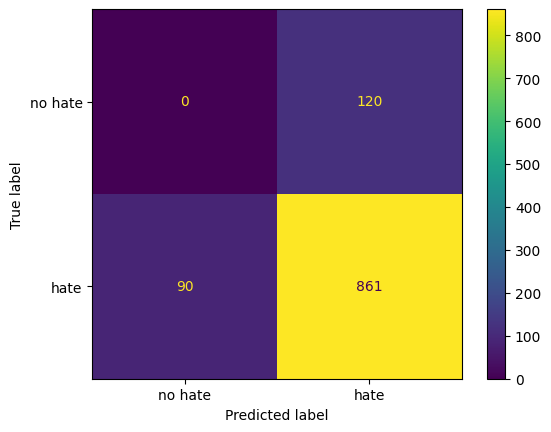

In [ ]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no hate", "hate"])
disp.plot()
plt.show()

Text(0, 0.5, 'Accuracy (%)')

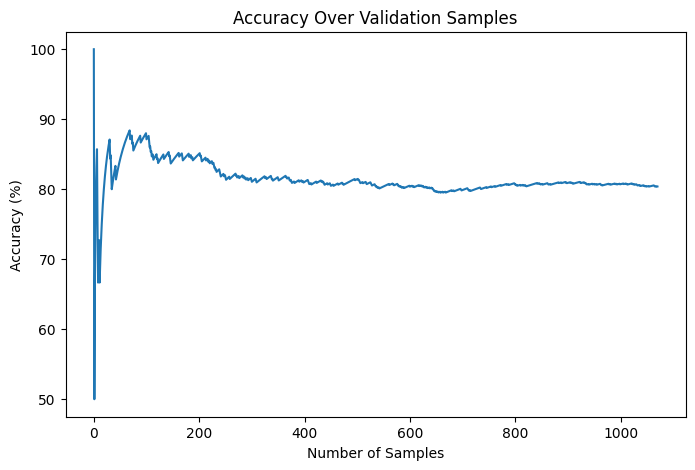

In [ ]:
accuracies = np.cumsum(np.array(all_labels) == np.array(all_preds)) / np.arange(1, len(all_labels) + 1)
plt.figure(figsize=(8, 5))
plt.plot(accuracies * 100)
plt.title("Accuracy Over Validation Samples")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy (%)")